<center>
<img src="https://drive.google.com/uc?export=view&id=1VkGbtJX9Ezh187IsbMKe7wgXkaR5o79k" width=640 />
</center>

<br/>

<font size=6>
<center>Lesson 3: Transformers
</center>
</font>

<font size=4>
<center><i>Understanding the architecture behind recent NLP breakthroughs</i>
</center>
</font>




# 1. Introduction

## Lesson Overview

In the previous lesson, we trained a linear model to make predictions based on some text data. Now, we’re moving on to more advanced models: **transformers**. In this lesson, you’ll:



* Learn the basics of neural networks and how the differ from linear models
* Understand transformer architecture and how to use it with text data
* Practice training transformer models with the Hugging Face library

_Note: in this lesson, we borrow some materials from the fantastic [NLP course](https://lena-voita.github.io/nlp_course.html) by Lena Voita. If you need some additional explanation after this lesson, we suggest taking a look – actually, it’s not a bad idea to look even if you feel solid._

<center><img src="https://drive.google.com/uc?export=view&id=1yX2D4GbMQyUAfumAGJiavyCiBKZLc_ui" width=1000 /></center>

## Why Use Neural Networks: Non-Linear Problems

Linear models are interpretable but too simple for most real-life tasks. Consider, for instance, the following 2-dimensional classification problem:

<center>
<img src="https://drive.google.com/uc?export=view&id=1ywNu-crPjvHLAIqngLlNP6Bxki7ehUY8" width=400 />
</center>

Obviously, no straight line could separate these two classes, so a linear classifier would be useless here. At the same time, the classification problem itself is very easy. Quite clearly, a dotted red circle perfectly separates the classes, so a simple rule that compares the _distance between the data point_
$x$
_and the origin_ with, say,
$0.6$
 will solve the problem.

We can do a little hack and introduce a **new feature** $x_1^2 + x_2^2$
 (it's the squared distance from the origin):


$$
(x_1, x_2)\longrightarrow (z_1, z_2, z_3) = (x_1, x_2, x_1^2 + x_2^2)
$$


Now, we can pass this 3-feature problem to a linear model, which will crack the task easily:


$$
0\cdot z_1 + 0\cdot z_2 + 1\cdot z_3 - 0.6^2 > 0 \text{ then class 1, else class 0}
$$

## Constructing New Features

If we have a real-world problem which is more complex, but not visually solvable, constructing new features can be tricky. There is even a separate craft known as **feature engineering** that combines some math and empirical knowledge to create sometimes very complicated features. And just to give you an idea: before the rise of neural networks, NLP specialists used word frequencies coupled with various normalizations, or even complex formulas with empiric coefficients like [BM25](https://en.wikipedia.org/wiki/Okapi_BM25). These carefully engineered features were then fed to something like a linear model, with the whole pipeline looking like this:


<center>
<img src="https://drive.google.com/uc?export=view&id=1x8t3131WJFoZYzhVWayepaK5-h0tj432" width=400 />


*Image from the [NLP For You course by Lena Voita](https://lena-voita.github.io/nlp_course.html).*
</center>

But deep learning changed all of that. One of the greatest things in deep learning is that we can simultaneously learn both **feature representations** and the **final classifier**. But how? Let's see in the next section!

# 2. A Gentle Intro to Neural Networks

## Decomposing The Classification Rule

Let's return to our example with two circles, but this time, let's consider a different classification rule:

<center>
<img src="https://drive.google.com/uc?export=view&id=13HOWy3Si9sVfSrRVHS4TtbedEnREU2K_" width=400 />
</center>

This also solves the problem, and it will be easier for us to work with. Let's write down this rule as a formula; one way to do so is to compute the following expression and later compare it with zero for the answer:


$$
\max\left(0,x+y-0.75\right)+\max\left(0,x-y-0.75\right)+\max\left(0,-x-y-0.75\right)+\max\left(0,-x+y-0.75\right)
$$

If it’s positive, we predict class 1, and if it’s negative, we predict class 0. Feel free to verify that it works with any plotting tool, for example, with [Desmos](https://www.desmos.com/Calculator).

While it looks scary, it can be decomposed into three simpler stages:

<br/>

$$
(x_1, x_2)\longrightarrow
$$

<br/>

$$\longrightarrow(z_{11}, z_{12}, z_{13}, z_{14}) = (x+y-0.75,x-y-0.75,-x-y-0.75,-x+y-0.75)\longrightarrow$$

<br/>

$$\longrightarrow(z_{21}, z_{22}, z_{23}, z_{24}) = (\max(0,z_{11}), \max(0, z_{12}), \max(0, z_{13}), \max(0, z_{14}))\longrightarrow$$

<br/>

$$\longrightarrow z_4 = z_{21} + z_{22} + z_{23} + z_{24}$$

<br/>

The first and the third are linear transforms, while the second is an elementwise **nonlinearity**; in this case, the function is known in deep learning as **ReLU** (Rectified Linear Unit):


$$
\text{ReLU}(t) = \max(0, t)
$$

<center>
<img src="https://drive.google.com/uc?export=view&id=1oBnSTTp3THYbOciKB82KMJpO0EqO08EE" width=360 />
</center>

If we want to predict the _probability of class 1_, we can apply the **sigmoid** function to the final result:

$$\sigma(z) = \frac1{1 + e^{-z}}$$

The sigmoid function has values between $0$ and $1$ (so it can be a probability); and moreover, the higher the value of $z$, the higher the predicted probability. Let's see the plot:



<center>
<img src="https://drive.google.com/uc?export=view&id=1E0o_Xb9oj7-1eTrgD3EaehCA49ROsOJU" width=360 />
</center>



So, $\sigma(z_4) > \frac12$ for positive $z_4$ and vice versa.


<br/>

<details>
    <summary><font color="404090">A note of the sigmoid-softmax relation (click to expand)</font></summary>

Note: the sigmoid function is closely related to the softmax function introduced in the previous lesson:

$$\text{softmax}(-z, z) = (1 - \sigma(z), \sigma(z))$$

<br/>
</details>

## Layers And Parameters

That’s all good, but the lengthy formula above seemed to just appear miraculously. How can we arrive at the same function with machine learning?

Remember, the linear models from the previous lesson are actually **parametric** (that is, they have parameters or weights that can be learned from data). So, let's make our current formula parametric too:

<br/>

$$(x_1, x_2)\longrightarrow$$

<br/>

$$\begin{align}\longrightarrow(z_{11}, z_{12}, z_{13}, z_{14}) =\,(
&\color{magenta}{w_{11}}x_1+\color{magenta}{w_{12}}x_2+\color{magenta}{w_{10}},\\
&\color{magenta}{w_{21}}x_1+\color{magenta}{w_{22}}x_2+\color{magenta}{w_{20}},\\
&\color{magenta}{w_{31}}x_1+\color{magenta}{w_{32}}x_2+\color{magenta}{w_{30}},\\
&\color{magenta}{w_{41}}x_1+\color{magenta}{w_{42}}x_2+\color{magenta}{w_{40}}\,)\longrightarrow\end{align}$$

<br/>

$$\longrightarrow(z_{21}, z_{22}, z_{23}, z_{24}) = (\max(0,z_{11}), \max(0, z_{12}), \max(0, z_{13}), \max(0, z_{14}))\longrightarrow$$

<br/>

$$\longrightarrow z_3 = \color{magenta}{u_1}z_{21} + \color{magenta}{u_2}z_{22} + \color{magenta}{u_3}z_{23}+ \color{magenta}{u_4}z_{24} + \color{magenta}{u_0}$$

<br/>

$$\longrightarrow z_4 = \sigma(z_3)$$

<br/>

All the $\color{magenta}{w}$'s and the $\color{magenta}{u}$'s are trainable parameters here. And note a slight difference in the linear formula (the first step) from the previous lesson: we’ve also added a set of **bias** parameters $\color{magenta}{w_{10}}, \ldots, \color{magenta}{w_{40}}$; these are not multiplied by any inputs and are just added to our formula; the bias is present in the actual full linear model, but we skipped it in the last lesson for simplicity.

And this is our first **neural network**! It has 4 **layers**:

* `Linear(2, 4)` maps a length 2 vector to a length 4 vector and has trainable weights $\color{magenta}{w}$
* `ReLU()` applies ReLU to every element of a vector, it has no trainable parameters
* `Linear(4, 1)` maps a length 4 vector to a length 1 vector and has trainable weights $\color{magenta}{u}$

* `Sigmoid()` applies $\sigma$ to the previous result, it has no trainable parameters

Notice here how we’ve denoted each layer as if we are initializing some class instance, passing all the necessary configurations into it. This is actually how it’s done in many deep learning frameworks, so we’ll stick with this notation.

<details>
    <summary><font color="404090">A note on our formula’s math notation
 (click to expand)</font></summary>
    
The formula
$$\begin{align}(z_{11}, z_{12}, z_{13}, z_{14}) =\,(
&\color{magenta}{w_{11}}x_1+\color{magenta}{w_{12}}x_2+\color{magenta}{w_{10}},\\
&\color{magenta}{w_{21}}x_1+\color{magenta}{w_{22}}x_2+\color{magenta}{w_{20}},\\
&\color{magenta}{w_{31}}x_1+\color{magenta}{w_{32}}x_2+\color{magenta}{w_{30}},\\
&\color{magenta}{w_{41}}x_1+\color{magenta}{w_{42}}x_2+\color{magenta}{w_{40}}\,)\end{align}$$
    
may be written shorter using matrix multiplication:
    
$$(z_{11}, z_{12}, z_{13}, z_{14}) = (x_1, x_2)\cdot\color{magenta}{W} + \color{magenta}{b},$$
    
where
    
$$\color{magenta}{W} = \begin{pmatrix}
\color{magenta}{w_{11}} & \color{magenta}{w_{12}}\\
\color{magenta}{w_{21}} & \color{magenta}{w_{22}}\\
\color{magenta}{w_{31}} & \color{magenta}{w_{32}}\\
\color{magenta}{w_{41}} & \color{magenta}{w_{42}}
\end{pmatrix}$$
    
and
    
$$\color{magenta}{b} = \begin{pmatrix}
\color{magenta}{w_{10}}\\
\color{magenta}{w_{20}}\\
\color{magenta}{w_{30}}\\
\color{magenta}{w_{40}}
\end{pmatrix}$$
    
The matrix and vector notation help a lot for shortening the formulas, for details, see [this page](https://en.wikipedia.org/wiki/Matrix_multiplication)
</details>

To train this network, we take a suitable loss function and optimize all of the $\color{magenta}{w}$'s and $\color{magenta}{u}$'s with a gradient descent. Just a quick refresher on the general concept of gradient descent:

1. Start with random weights
2. Compute the negative gradient of the loss function (the direction in which it decreases the fastest)
3. Move the current weights slightly in this direction
4. Repeat from step 2 until convergence

And here’s some good news: allmodern neural network packages are able to compute the negative gradient automatically, so this algorithm is not very hard to implement.

## Constructing Neural Networks

Neural networks are built from layers like a toy house is built from the pieces of a construction set. Right now, we have just a few layers to work with (`Linear`, `ReLU`, `Sigmoid`, and `Softmax`), but we can use them to create very complex architectures. For example, if we have a 5-class classification problem on a dataset with 100 features, we could use something like this:

```{python}
Linear(100, 200)
ReLU()
Linear(200, 400)
ReLU()
Linear(400, 400)
ReLU()
Linear(400, 5)
Softmax()
```

A neural network with many layers can be called "deep" – hence the term **“deep learning”**.

Please note several important things:



* The dimensions of adjacent linear layers correspond to each other. For instance, the first linear layer outputs a vector of length 200; ReLU doesn't change the length, so the input of the second linear layer should also be 200
* Between every two layers there is a nonlinearity. This may be something other than ReLU, but we don't stack linear layers without nonlinearity, because several linear layers stacked directly are equivalent to just one linear layer
* The output of the final linear layer has a dimension equal to the number of classes, and the softmax outputs class probabilities
* The training will be focused on parameters of four linear layers

**Question**: How many trainable parameters does this network have?

<details>
    <summary><font color="404090">Answer (click to expand).</font></summary>
    
A `Linear(m,n)` layer has $(m+1)n$ parameters. Indeed, each of the $n$ coordinates of the output equals $$z^{(next)}_{i} = \color{magenta}{w_{i1}}z^{(prev)}_1+\ldots+\color{magenta}{w_{im}}z^{(prev)}_m + \color{magenta}+\color{magenta}{w_{i0}}$$ Don't forget about the bias! So, in our example we have

$$
101\cdot 200 + 201\cdot 400 + 401\cdot 400 + 401\cdot 5 = 263005
$$

This is actually quite an impressive number. And much more than just the 101 parameters of a linear model. This can allow the network to capture complex dependencies.
</details>

Of course, the choice of architecture (the number of layers, the dimensions,  nonlinearities, etc.) is crucial for the quality of the model. Moreover, you can't simply check all possible architectures because training each of them may take too much time and compute. That's why, excluding a thin stratum of tech companies and research labs, engineers typically don't invent their own architectures, instead reusing existing ones known for high performance. Accordingly, in this short course, we’ll also be working with existing models.

## Is That It?

The idea of stacking several transformations isn't too elaborate, so you might wonder why the deep learning revolution only happened in 2012.

The truth is that multilayered neural networks first appeared as early as in the 1960s and significant research was being invested into them long before 2012. However, the lack of two things impeded the application of neural networks in real-world tasks:

**1) Large datasets**. Deep neural networks usually have many trainable parameters. For example, our 8-layer network above has more than 200,000 parameters while the network AlexNet (which in 2012 was state-of-the-art in Computer Vision) had 60 million parameters. To train a network with so many parameters, we need millions of training images, otherwise the network will overfit. In Computer Vision, the first dataset that allowed us to train really large models was [ImageNet](https://image-net.org/). Since then, the models have only continued to grow in size. For example, ChatGPT-4 is said to have some 100 trillion parameters. So, large datasets remain a vital resource for the creation of state-of-the-art models.

**2) Computational resources**. Even if you could fit AlexNet and all the byproducts of the training process in your laptop's memory, training on the CPU would take ages. Thus, deep learning researchers needed more advanced infrastructure. Luckily, using **GPUs** (Graphical Processing Units) greatly speeds up training and prediction for neural networks, and this made AlexNet possible. Now, most cloud providers (Google Colab included) allow the use of GPUs. That said, training of state-of-the-art models like GPT-4 can only be done on huge multi-GPU clusters.

<center>
<img src="https://drive.google.com/uc?export=view&id=1aEWAD_B4MgFKq6JmK0OPzxadU2N5hhnu" width=400 />
</center>


# 3. Neural Networks for Texts

In the examples above, we described neural networks for data with just two numerical features: $x$ and $y$. But how to fit a text into a model like this? We could use the Bag of Words approach, but as we mentioned before, there's a problem with it: the features extracted by it don't take word order into account. In other words, sentences "The room was bad, I did not like it" and "The room was not bad, I did like it" will give us the same feature vectors.

Now that we’re using advanced models, we don't want to lose that much important information.

In this section, we’ll learn how to work with texts in a more clever way.

But first, we need some tools! Luckily, these days, we can work with neural networks without much coding – for example, [Hugging Face](https://huggingface.co/docs), which we used for datasets in the previous lesson, also contains many useful deep learning libraries. Here are the new ones we’ll be using in this lesson:



* **Tokenizers** for building features from texts
* **Transformers** for more advanced machine learning models

(Addressing all of the features of Hugging Face is beyond the scope of this text, but we’ll link to some deeper learning materials at the end of this lesson.  

## Dataset

Let's start by reviewing our dataset. We’ll be using the same Yelp reviews dataset as before, which contains review texts  and their sentiments.

In [ ]:
!pip install -qq datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 16.1.0 which is incompatible.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 16.1.0 which is incompatible.


In [ ]:
from datasets import load_dataset
dataset = load_dataset("yelp_review_full")
dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/650000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 650000
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 50000
    })
})


Let's also refresh our memory about the columns we’re working with:

In [ ]:
dataset.column_names

{'train': ['label', 'text'], 'test': ['label', 'text']}

... and about the features format:

In [ ]:
dataset['train'].features

{'label': ClassLabel(names=['1 star', '2 star', '3 stars', '4 stars', '5 stars'], id=None),
 'text': Value(dtype='string', id=None)}

## Text Tokenization

We promised to show a clever way of getting numeric representations for texts, and here's that trick: _instead of making a feature vector for the whole text, we make a vector for each word!_ Like this:

<center>
<img src="https://drive.google.com/uc?export=view&id=1CFN7YX5xTDZgPJDbCPryv4YuESv5zaEa" width=400 />

*Image from the [NLP For You course by Lena Voita](https://lena-voita.github.io/nlp_course.html).*
</center>



These vectors are created in a pretty straightforward way: we just create a dictionary with each word having its own vector (this is called **embedding**), and then we train these vectors together with the whole network (they become model **parameters**).

We’ll return to these embeddings later, but right now, let's understand why working with words (as we did in the previous lesson) may actually not be the best idea:

1. There are just too many words. Keeping so many vectors may be excessively memory intensive.

2. Even if we could somehow, the list of words will be set after training . However, in real life it's not possible to make an exhaustive list of all words: names, typos, abbreviations, and constantly-updating slang will turn our life into a nightmare.

This process of converting a raw text into some kind of units is called **tokenization** and each unit is called **token**. After this, we store the correspondence between tokens and some kind of vector in our dictionary.

So, we don’t want to use the tokenization strategy from the previous lesson, and we need some other tokenization strategy.

One possible solution could be **character level tokenization**. That is, each character is considered a separate token, and the whole text is treated just as a stream of characters. This could help to deal with misspellings and rare words, but the main drawback is that the task becomes harder —  in addition to learning how words compose into sentences, the network would also need to learn how characters compose into words. This would require more complex models, more data, more compute power, and more memory. For this reason, character tokenization is rarely used in practice.

Luckily, there are intermediate options between character and word tokenization that preserves all the input information and some of the input structure. These are **subword tokenization** strategies.These include BPE (Byte Pair Encoding) and WordPiece, which split some words into parts (sometimes into separate symbols), and leave their own tokens for other words. Here’s a rough idea on how to choose which words to split:



* Keep frequent words unbroken, because there is a lot of data on their contexts, and it will help the neural network learn their connections to other words.
* Split rare words into smaller units, because it will help keep down the size of the vocabulary and maybe even allow the network to deduce some meaning of the word based on its parts.

Let's check out an example to understand how it works: we’ll need to install a new library called `transformers` for this, and we’ll also use a model called BERT (we’ll explain what all of that means later in this lesson).

In [ ]:
!pip install -qq transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 53.6 MB/s eta 0:00:00


In [ ]:
from transformers import AutoTokenizer

bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
# there is a deliberate typo in word "neural"
example = "In this course we unravel the mysteries of nevral networks."
encoding = bert_tokenizer(example)
print(type(encoding))

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

<class 'transformers.tokenization_utils_base.BatchEncoding'>


In [ ]:
print(encoding.tokens())

['[CLS]', 'In', 'this', 'course', 'we', 'un', '##rave', '##l', 'the', 'mysteries', 'of', 'ne', '##v', '##ral', 'networks', '.', '[SEP]']


Some notes: the double hash sign `##` denotes that the token is not a new word, but a continuation of the previous one. The word ”unravel” is rare, so it was split into three tokens: “`un`”, “`##rave`”, “`##l`”. The word “nevral” has a typo, so it was also split: “`ne`”, “`##v`”, “`##ral`”.

Note also that there are some special tokens in the list (`[CLS]`, `[SEP]`), which are not very important for us at the moment.

<center>
<img src="https://drive.google.com/uc?export=view&id=1oHszvlMpGV2Evws7HiwwONa9uaXlA-_J" width=700 />
</center>


Let's play with the BERT tokenizer a little bit to get more understanding how it works.

As we've mentioned, the tokenizer tries to produce separate tokens for frequent words and split less frequent into parts.

**Exercise.** Find 2 words that have their own tokens and 2 words (existing and without typos) that were split into two separate tokens.

In [ ]:
# <your code here>



In [ ]:
# <SOLUTION>

# 2 words that have their own tokens
print(bert_tokenizer("cat computer").tokens())

# 2 words that are split
print(bert_tokenizer("neuron transformer").tokens())

['[CLS]', 'cat', 'computer', '[SEP]']
['[CLS]', 'ne', '##uron', 'transform', '##er', '[SEP]']


Now, splitting words into parts for vocabulary reduction is great, but how useful are the created tokens for the downstream neural network? If some of the partial tokens repeat consistently between different words, it can be useful, as the network would be able to deduce some grammar rules from it for example.



**Exercise.** Find 2 different words split into parts by the tokenizer where the first part is the same token. Then, find 2 different words with the last part being the same token.

In [ ]:
# <your code here>




In [ ]:
# <SOLUTION>

# 2 words with the same start
print(bert_tokenizer("transformer transformable").tokens())

# 2 words with the same end
print(bert_tokenizer("transformable manageable").tokens())

['[CLS]', 'transform', '##er', 'transform', '##able', '[SEP]']
['[CLS]', 'transform', '##able', 'manage', '##able', '[SEP]']


Finally, let's think about this – does this way of splitting tokens actually help reduce the vocabulary size? Because, for many words, this tokenizer actually creates more words, and it will only help in the long run if there are many similar word parts.

**Exercise.** Find out how the vocabulary size depends on the size of the dataset for simple word tokenization and our BERT tokenizer. Since training new tokenizers is very compute-heavy, we’ll just find the number of unique tokens for each of the tokenizers depending on the subset size. Plot those values as graphs to see the dynamics more easily. Tokenizing the entire dataset will take too much time, so just try to find a size where the size of the BERT vocabulary becomes smaller than the words vocabulary.

We’ve already implemented both of the tokenizers as simple functions below.

In [ ]:
import re

def word_tok(text):
    return re.findall('(?u)\\b\\w\\w+\\b', text)

word_tok("In this course we unravel the mysteries of nevral networks.")

['In',
 'this',
 'course',
 'we',
 'unravel',
 'the',
 'mysteries',
 'of',
 'nevral',
 'networks']

In [ ]:
def bert_tok(text):
    return bert_tokenizer(text).tokens()

bert_tok("In this course we unravel the mysteries of nevral networks.")

['[CLS]',
 'In',
 'this',
 'course',
 'we',
 'un',
 '##rave',
 '##l',
 'the',
 'mysteries',
 'of',
 'ne',
 '##v',
 '##ral',
 'networks',
 '.',
 '[SEP]']

In [ ]:
# <your code here>




  0%|          | 0/500 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1074 > 512). Running this sequence through the model will result in indexing errors


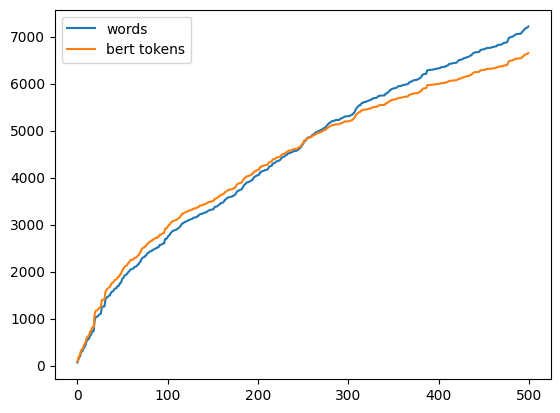

In [ ]:
# <SOLUTION>

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

word_vocab = set()
bert_vocab = set()

word_lens = []
bert_lens = []

for i in tqdm(range(500)):
    text = dataset["train"]["text"][i]

    word_vocab = word_vocab.union(set(word_tok(text)))
    bert_vocab = bert_vocab.union(set(bert_tok(text)))

    word_lens.append(len(word_vocab))
    bert_lens.append(len(bert_vocab))


plt.plot(word_lens, label="words")
plt.plot(bert_lens, label="bert tokens")
plt.legend()

## Dataset Preprocessing

Let's return to our sentiment analysis problem. We need to tokenize our dataset before starting to run models on it. Training large models requires lots of computational power, so, for demonstration purposes we’ll just use a tiny fraction of the data.

In [ ]:
small_train_dataset = dataset["train"].shuffle(seed=42).select(range(1000))
small_eval_dataset = dataset["test"].shuffle(seed=42).select(range(1000))

There is a function `map` in the Hugging Face datasets that we can use to apply the tokenizer to the whole set. We just need to define a mapping function:

In [ ]:
def preprocess_function(examples):
    return bert_tokenizer(
        examples["text"],
        padding="max_length",   # see explanation below
        truncation=True)   # see explanation below

There are two additional parameters in the tokenizer that will help us later. In short, we want all of the texts in our dataset to have the same length, so we ask the tokenizer to pad small texts with special "empty" tokens and truncate texts that are too long.

Having the exact same length is only important to get faster, more convenient model training; the model is still able to process texts of various lengths if necessary.

Now, let's apply the mapping:

In [ ]:
# batched=True just helps to process things faster
small_train_dataset_tok = small_train_dataset.map(preprocess_function, batched=True)
small_eval_dataset_tok = small_eval_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

## Transformers

Now, the fun part: applying neural networks to our domain task. We’ll focus on the most popular architecture in NLP nowadays: **transformer-based** models.

The original transformer model is based on on the **encoder-decoder** architecture:

* **Encoder** part converts the input sequence of tokens into a sequence of embedding vectors.
* **Decoder** part generates an output sequence of tokens, one step at a time, using the encoder's output.


<center><img src="https://drive.google.com/uc?export=view&id=19D0hMWMKa2-wqt-6GN-RtoDwxvmb2AD-" width=700 /></center>

A good example of a task that uses both components is **machine translation**: a sequence of tokens in a source language is encoded via an encoder and later translated into tokens of another language using a decoder; the image above schematically represents English to French translation.

However, in some tasks you don't need both parts to solve a problem:



* **Decoder-only** models are used in generation tasks. For example, **GPT** (generative pre-trained transformer) models are decoder-only models (we’ll talk about this more in the next lesson).
* **Encoder-only** models are able to extract meaningful vector representations of tokens that can be used for tasks like text classification. (Examples include **BERT** and its variants, like **RoBERTa** and **DistilBERT**.) We will use encoder-only models in this lesson.

Now, let's dive into the anatomy of encoder-only transformer models and we’ll understand how to apply them to the classification task.

### Attention Mechanism

Let's start with the core mechanism in the transformers architecture: **attention**.This processes sequences of embeddings together and enables the exchange of information between them. Roughly speaking, the embedding of each token "_pays attention_" to the embeddings of all other tokens and "_draws conclusions_" from it.

<details>
    <summary><font color="404090">A funny story about the name “attention” (click to expand)</font></summary>
  
Attention mechanism was introduced before the transformers, and in other architectures it was used alongside other important sequence processing techniques. However, the paper that introduced transformers suggested to make attention the core mechanism of the architecture and remove most of the other techniques. Naturally, the paper was named [Attention Is All You Need](https://arxiv.org/abs/1706.03762).
</details>

We'll describe the most popular version of the attention mechanism: **scaled dot-product attention**. There are few main steps required to implement this mechanism:

**Step 1.** Map each token's embedding into three vectors called **query**, **key**, and **value**. To do this we multiply each vector $x_i$ by trainable matrices:

- $W_Q$ for queries
- $W_K$ for keys
- $W_V$ for values


<center>
<img src="https://drive.google.com/uc?export=view&id=1GPWfojsEXhawctXqyUlv0HZe9wgfrs9G" width=600 />
</center>

The names "query", "key", and "value" reflect what will be done with them:

* **Query** $q_i = W_Qx_i$ is the "probe" used by the $i$-th token to "look" upon all other tokens.
* **Key** $k_i = W_Kx_i$ is the signal that $i$-th token sends to the probes to catch their attention. Both queries and keys are the vectors of the same length $d$.

**Step 2.** The actual act of  "paying attention" is performed by computing the scalar product

$$
\langle q_i, k_j\rangle = q_{i1}k_{j1} + \ldots + q_{id}k_{jd},
$$

which tells us how much attention the $i$-th token will pay to the $j$-th token.

<center>
<img src="https://drive.google.com/uc?export=view&id=1R8Tdvnv6ZRGa3Wb0CvxxDjp7mflJEGo2" width=480 />
</center>

**Step 3.** Now that all tokens have decided how much attention they should pay to each other, they’re ready to take the **values** $v_i = W_Vx_i$ and use the information inside them. Each token updates its embedding like so:


$$
x'_i = x_i + w_{i1}v_1 + w_{i2}v_2 + \ldots + w_{iN}v_N,
$$


where $N$ is the sequence length and $w_{ij}$ are called **attention weights**, and these are computed this way:

$$
(w_{i1}, \ldots, w_{iN}) = \text{Softmax}\left(\frac{\langle q_i, k_1\rangle}{\sqrt{d}}, \ldots, \frac{\langle q_i, k_N\rangle}{\sqrt{d}}\right)
$$

<center>
<img src="https://drive.google.com/uc?export=view&id=1481GOkcGqGJaTFnLL4nFo5PmVpbNIri6" width=400 />
</center>

So, we mix the information provided in the values with the coefficients that show how much attention we should pay for each of the tokens.

**Why do we need Softmax?** Softmax is the function we mentioned in the previous lesson:

$$
\text{Softmax}(z_1,\ldots,z_N) = \left(\frac{e^{z_1}}{\sum_je^{z_j}}, \ldots, \frac{e^{z_N}}{\sum_je^{z_j}}\right)
$$

It turns a tuple of numbers into a valid probability distribution, that is, a tuple of non-negative numbers that sum to 1.

This helps the attention layers mix the values without changing the overall scale.

Here’s an overview diagram of the whole attention concept:

<center><img src="https://drive.google.com/uc?export=view&id=16sGrMsKVcJah28CLeEKToiaLZOchKKIf" width=700 /></center>

### Transformer Block

There are several other important parts in the architecture that help the attention mechanism process information better. Let’s discuss those.

**Feed-forward layer:** This layer has three sublayers applied independently to each of the embeddings:

1. Linear transformation
2. Non-linearity (ReLU in the original Transformer)
3. Linear transformation (again)

This block is added after each attention block and allows the model to do some additional processing of the information gathered in between various tokens.

**Residual connections:** After applying attention to the embeddings, we add the results to the initial $x_i$ to obtain $x_i'$ (without any weight). This has proven to be beneficial for training, and intuitively it allows us to pass more information about the initial vectors through the pipeline with the new information received from the attention mechanism.

<center>
<img src="https://drive.google.com/uc?export=view&id=1zqnVOLlSVkEeme9anRvX8sgI1DN_pfCq" width=400 />
</center>

The mechanism of adding the initial vectors to the transformed ones is known as a **residual connection**, or **skip connection**, the same thing is also applied to the feed-forward layer.

**Normalization:** There is one more technique that helps train this model better: normalizing the embedding vectors between meaningful layers. We won't dive too deep into how it works, but the core idea is to make the entire set of all embeddings have zero mean and unit variance. This helps the layer at least know the scale of values in order to expect them and help learn faster.

All together, these things form a **transformer** building block, that we’ll later just copy and stack to get the full thing:


<center><img src="https://drive.google.com/uc?export=view&id=1ayRRaOyGcsnszxW36RNcz9XYz_yYrb7D" width=400 /></center>

### Token Embeddings

As we said before, the input tokens are transformed into **embeddings** by just creating a dictionary of embedding vectors for each token and training them.

However, perhaps you’ve noticed that the order of tokens doesn't matter anywhere in the transformer architecture, so we need an additional mechanism to account for them. This is  done with special **positional embeddings **which are added to the initial token embeddings before feeding them to the encoder:

<center>
<img src="https://drive.google.com/uc?export=view&id=1CsITa1y7Q6zoGQA_rZTwMrrjBaU7k6BA" width=420 />
</center>


### Overall Encoder Architecture


To get a transformer encoder we just need to stack several transformer blocks. Here is how the full thing looks like:

<center>
<img src="https://drive.google.com/uc?export=view&id=1qPNW7j7X7u0n4serAqEtU0oZHr2wRnV5" width=400 />
</center>


_Note: We omitted several things  crucial for training but not that important for your first acquaintance with the material._

## Classification with Transformers

In the previous section, we built a transformer encoder that takes a sequence of token embeddings as input and produces a new sequence of **output embeddings**. One last step is missing: how do we convert this sequence of output embeddings into label prediction for our classification task?

The idea is to summarize all the information in those output embeddings and pass it into a linear classifier. We’ll take the following steps:


1. Take the average of all the output embeddings vectors (this is called **pooling**)
2. Add a `Linear(d, k)` layer where d is the dimension of the output embeddings and k is the number of classes
3. At the end, add `Softmax()`


<center><img src="https://drive.google.com/uc?export=view&id=16tZ-Hphhc0zhDrREvvmAEf9Ti7aSKLrA" width=400 /></center>

The resulting network is ready to predict class probabilities and can be trained with cross entropy loss and gradient descent as usual.

Now that we understand how transformers work, let's do some training! However, training the whole transformer model from scratch is too computationally heavy, so we’ll need some other approach.

# 4. Fine Tuning with Hugging Face

If training a large model isn’t feasible, there’s another approach we can use that is called **fine-tuning**. The idea behind this method is taking a model that’s already been trained on another similar dataset (this is called a **pre-trained** **model**) and then do some additional training on our dataset.

We’ll discuss pre-training and fine-tuning further in the following lessons, but for now, let's just take some already trained model and play with it. As we've already said, the model of choice for this lesson is called **BERT** (Bidirectional Encoder Representations from Transformers), which is just a good, reliable language model from Google that can be fine-tuned on any text task. As we see from its name, it’s a transformer-based model, with some tweaks that are not important for our task.

## Before Training

Even for fine-tuning, we’ll need to use the GPU, otherwise training will take ages. Here’s the code to check if the GPU is available:

In [ ]:
import torch

# save the best available device to a variable to use over all the following code
# GPU is crucial for training, but we can do debugging on CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Let's load the model (which already contains both the transformer and classifier) and specify the number of classes we need to predict:

In [ ]:
from transformers import AutoModelForSequenceClassification

# create and load the model
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=5)

# move the model to the device set up above
model.to(device)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

The auto-models in Hugging Face help us quickly create and load models, and in the code above we specify that:

* The model type is "sequence classification"
* The pretrained encoder for the model is BERT
* The classification head has 5 outputs (5 classes) and it is not trained (not loading any weights)

With the model ready, we need to set up the training. This is done using the `Trainer` class in transformers, which in turn needs a `TrainingArguments` object for initialization. All those classes are necessary because there are a lot of ways the training can be customized and tweaked, and this is the way the Hugging Face has provided an interface for this.

Here’s a simple way of initializing those classes – let's take a look and then talk about what some of these arguments mean:

In [ ]:
from transformers import TrainingArguments, Trainer

# we will explain what is the batch size below
BATCH_SIZE = 16

training_args = TrainingArguments(
   output_dir='./output',  # a place to save some training stuff, not important to us
   per_device_train_batch_size=BATCH_SIZE,  # just special names for batch size, not important to us
   per_device_eval_batch_size=BATCH_SIZE,
   num_train_epochs=5,   # we will explain what epoch is below
)

trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=small_train_dataset_tok,
   eval_dataset=small_eval_dataset_tok,
)

Let's understand two very important hyperparameters of the training: **batch size** and **number of epochs**. First, a quick refresher about our optimization algorithm, **gradient descent**:


1. Choose a random starting value for the weight vector $w$.

2. Repeat $N$ times:

    - Compute the loss function $L(w)$ and its gradient $\nabla L(w)$.

    - Update the weights by moving them into the direction of negative gradient, multiplying it by learning rate:

    $$
        w = w - \alpha \nabla L(w)
    $$

The thing is, in practice, there’s a problem with this algorithm: if a dataset is very big, computing the loss function and the gradient on the whole dataset will take a lot of time. Luckily, there is a simple trick that can speed this up dramatically – instead of computing the gradient of the loss function on the entire dataset, we can approximate it on just a small random subset (called a **batch**), and get a new subset on each step.

This new algorithm is called **stochastic gradient descent** or **SGD**. In practice, instead of choosing a new random subset on each step, we usually just shuffle the whole dataset, split it into batches, and go over them one by one. If we run out of batches and want to do more steps, we just reshuffle and re-split the dataset. Each pass over the whole dataset is called an **epoch**.

Here are some important points on how to organize training with these hyperparameters:



* **Role of batch size $B$: computation vs. stability**: The larger $B$, the more stable the optimization. Sometimes, you just can't achieve anything meaningful with too small of a batch size. However, with a large $B$, the optimization can simply fail due to memory exhaustion. So, sadly, you can find that some models just won't train at all on your hardware. There are some hacks, like gradient checkpointing, to tackle this, but it goes beyond the scope of this course.
* **Role of number of epochs**: We usually need several epochs (and probably lots of them) to train a model. However, with small data a model can overfit after too many epochs. (And during fine tuning you usually don't have too much data.)
* **Monitoring in progress**: The training process can take hours (or even days), so you probably want to monitor its intermediate steps. Usually this is done after each epoch on a dedicated **evaluation dataset**. It’s important to perform this independent evaluation.
* **Algorithm modifications**: If you just ran SGD on a real world task with a realistically small batch size, the training would most likely fail. Additional modifications and hacks are needed to ensure (or at least to get closer to) stable training – there are many SGD-based methods, such as _AdaGrad_ or _Adam_. However, all of them still have the overall structure of the same batch-and-epoch process.


<center><img src="https://drive.google.com/uc?export=view&id=1hHkxOpCpM9VVAFNCvlj1be2rWAtO56Hm" width=320 /></center>

## Model Training


Before running the training, let's set up some more important things.

First, let's set up an accuracy metric (the ratio of the correct answers) in the format that the trainer can use for proper logging.

In [ ]:
import numpy as np
from datasets import load_metric

def compute_metrics(eval_pred):
    accuracy = load_metric("accuracy", trust_remote_code=True)

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    return {"accuracy": acc}

Now, let's set up the model and the trainer again, adding some more useful parameters.


In [ ]:
# Important: you need to re-run this line before each training to reset weights.
# Otherwise the model will continue training from previously saved weights.
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=5).to(device)

BATCH_SIZE = 16

training_args = TrainingArguments(
    output_dir='./output',
    overwrite_output_dir=True,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=5,
    # these lines will evaluate our model every 50 steps, so that we can see the progress
    logging_steps=50,
    evaluation_strategy="steps",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset_tok,
    eval_dataset=small_eval_dataset_tok,
    compute_metrics=compute_metrics,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


There are many more parameters in `TrainingArguments`, and if you’re interested you can see the full list of options in the [documentation](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments)

Finally, let's train the model!

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy
50,1.454800,1.130694,0.499000
100,1.055300,1.276384,0.464000
150,0.796800,0.997069,0.581000
200,0.593200,1.020053,0.604000
250,0.470500,1.087710,0.604000
300,0.275700,1.121752,0.609000


<ipython-input-22-d6d31ba30c44>:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy = load_metric("accuracy", trust_remote_code=True)


TrainOutput(global_step=315, training_loss=0.7479031979091584, metrics={'train_runtime': 652.9518, 'train_samples_per_second': 7.658, 'train_steps_per_second': 0.482, 'total_flos': 1315590712320000.0, 'train_loss': 0.7479031979091584, 'epoch': 5.0})

We can see the metrics in the log, but let's also evaluate the final model:

In [ ]:
trainer.evaluate()

{'eval_loss': 1.1336109638214111,
 'eval_accuracy': 0.605,
 'eval_runtime': 31.5301,
 'eval_samples_per_second': 31.716,
 'eval_steps_per_second': 1.998,
 'epoch': 5.0}

As you can see, the model improves over time, and the accuracy is rather good. However, in the previous lesson, we managed to get 60% with just the linear model, so this is kind of disappointing. Now, we’re obviously quite limited by the computational power here, but maybe it’s possible to get the quality just a little bit higher than the linear model? (We’ll see the full power of the model in the next section).

Note: The quality above may already be above the linear model due to some randomness, so we’ll push it up a little further still in the exercise below.

**Optional exercise.** Play with the training code and try to get the quality to at least 62% within a reasonable training time (less than 30 minutes).

<details>
    <summary><font color="404090">Hint (click to expand).</font></summary>
    
While it’s possible to get the desired quality just by playing with the parameter values in the code above, there’s actually an implicit parameter that can help dramatically improve the quality!
<br/>
</details>

<details>
    <summary><font color="404090">Hint 2 (click to expand).</font></summary>
    
If the dataset is too big for training, going over the same examples several times doesn't make sense.
<br/>
</details>

In [ ]:
# your code here






In [ ]:
# <SOLUTION>

# Instead of going over the small portion of the data several times,
# let's just get a bigger portion and go over it once.
small_train_dataset = dataset["train"].shuffle(seed=42).select(range(10000))
small_train_dataset_tok = small_train_dataset.map(preprocess_function, batched=True)

model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=5).to(device)

BATCH_SIZE = 16

training_args = TrainingArguments(
   output_dir='./output',
   overwrite_output_dir=True,
   per_device_train_batch_size=BATCH_SIZE,
   per_device_eval_batch_size=BATCH_SIZE,
   num_train_epochs=1,
   logging_steps=50,
   evaluation_strategy="steps",
   load_best_model_at_end=True,
)

trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=small_train_dataset_tok,
   eval_dataset=small_eval_dataset_tok,
   compute_metrics=compute_metrics,
)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy
50,1.441300,1.220808,0.447000
100,1.171200,1.091027,0.517000
150,1.148200,1.043748,0.536000
200,1.032400,0.985513,0.543000
250,1.020700,0.925476,0.578000
300,0.992800,0.946962,0.572000
350,0.971800,0.913157,0.598000
400,0.996300,0.886190,0.607000
450,0.968700,0.865867,0.618000
500,0.917600,0.874249,0.620000


TrainOutput(global_step=625, training_loss=1.0308398834228516, metrics={'train_runtime': 1337.2456, 'train_samples_per_second': 7.478, 'train_steps_per_second': 0.467, 'total_flos': 2631181424640000.0, 'train_loss': 1.0308398834228516, 'epoch': 1.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.8742488026618958,
 'eval_accuracy': 0.62,
 'eval_runtime': 31.3786,
 'eval_samples_per_second': 31.869,
 'eval_steps_per_second': 2.008,
 'epoch': 1.0}

## Running A Pre-Trained Model

Training a model from scratch, or fine-tuning one for a new large dataset of a different nature, will always take time (both in terms of engineering and compute). It will also require a lot of hardware, efficient pipelines, and a healthy amount of patience!

Let's make use of a small hack and take a model that was pre-trained by an enthusiast on the same dataset for solving the sentiment analysis on Yelp data (and later published for community), and we’ll apply it to our test part, then evaluate the performance.

(This is another great thing of the Hugging Face community – one can find a lot of open source models of different sizes, trained on various datasets for solving different tasks.)

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tuned_tokenizer = AutoTokenizer.from_pretrained("gilf/english-yelp-sentiment")
tuned_model = AutoModelForSequenceClassification.from_pretrained("gilf/english-yelp-sentiment").to(device)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

Notice that tokenizer and model are the same as before, just trained for longer time.

In [ ]:
tuned_tokenizer

BertTokenizerFast(name_or_path='gilf/english-yelp-sentiment', vocab_size=28996, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [ ]:
tuned_model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

**Exercise.** Evaluate this model on a subset of random 1000 samples from the test dataset. You can do this using an API or write your own loop, choose the approach you prefer.

**Important:** You cannot reuse the tokenized subset from the previous section because the tokenizer is different.

In [ ]:
# your code here






In [ ]:
# <SOLUTION 1 - Using Hugging Face API>

def preprocess_function_2(examples):
    return tuned_tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True)

# retokenize the data
small_eval_dataset = dataset["test"].shuffle(seed=42).select(range(1000))
small_eval_dataset_tok = small_eval_dataset.map(preprocess_function_2, batched=True)

# set up trainer with minimal parameters
BATCH_SIZE = 16
training_args = TrainingArguments(
   output_dir='./output',
   overwrite_output_dir=True,
   per_device_train_batch_size=BATCH_SIZE,
   per_device_eval_batch_size=BATCH_SIZE,
)
trainer = Trainer(
   model=tuned_model,
   args=training_args,
   eval_dataset=small_eval_dataset_tok,
   compute_metrics=compute_metrics,
)

trainer.evaluate()

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

{'eval_loss': 0.6529653668403625,
 'eval_accuracy': 0.735,
 'eval_runtime': 31.5392,
 'eval_samples_per_second': 31.707,
 'eval_steps_per_second': 1.998}

In [ ]:
# <SOLUTION 2 - Manual>

from sklearn.metrics import accuracy_score
import torch
from tqdm.notebook import tqdm

small_eval_dataset = dataset["test"].shuffle(seed=42).select(range(1000))
tuned_model.to(device).eval()  # enable evaluation mode

all_predictions = []

with torch.no_grad():  # disable gradient calculation for faster evaluation
    for text in tqdm(small_eval_dataset['text']):
        encodings = tuned_tokenizer.encode(text, return_tensors='pt', max_length=512).to('cuda')
        predictions = tuned_model(encodings)
        predicted_class = predictions.logits.argmax().tolist()
        all_predictions.append(predicted_class)


labels = small_eval_dataset['label']
acc = accuracy_score(labels, all_predictions)
print("Accuracy:", acc)

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.735


That's it! Pretty competitive quality for the vague task predicting sentiment on the scale from 1 to 5. However, there is always room for improvement: for instance, we could take a much bigger model and train it!

# 5. Conclusion

Let's wrap up what we've learned.

First, there was a lot of theory this time:



* Why using linear models isn’t enough for most tasks and why we need complex features to solve these tasks.
* How the concepts of **neural networks** and **deep learning** emerged and how we can train the classifier and features simultaneously.
* How the transformer model works and can be applied for text classification.

Then, we had practice with some code:



* We explored the Hugging Face libraries for working with tokenization and transformers.
* We **fine-tuned** a sequence classifier based on the pre-trained **BERT encoder**.
* We loaded the trained fine-tuned model and compared the quality of all the models.

Now that we've learned the basics about neural networks and NLP, in the next lesson, we’ll talk about **ChatGPT**: how it works, and how we can use it in different tasks.

If you’re interested, here are some additional resources on the things we talked about in this lesson:

* A great [NLP Course by Lena Voita](https://lena-voita.github.io/nlp_course.html), with a dedicated [section for attention and transformers](https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html).
* [NLP course by Hugging Face](https://huggingface.co/course/chapter1/2?fw=pt).
* [A tutorial](https://huggingface.co/docs/datasets/tutorial) on working with datasets using Hugging Face
* [A great visualization](https://3.bp.blogspot.com/-aZ3zvPiCoXM/WaiKQO7KRnI/AAAAAAAAB_8/7a1CYjp40nUg4lKpW7covGZJQAySxlg8QCLcBGAs/s640/transform20fps.gif) of the attention idea from the [blog post from Google](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html).
* [Tokenization internals in the Hugging Face](https://huggingface.co/learn/nlp-course/chapter6/1?fw=pt).